# <center> CFRM521 Machine Learning in Finance
## <center> Lecture 16
### <center> Yoshihiro Shirai

# Training Neural Networks, Part 3

- These lecture notes are partially based on "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 3rd Edition, by Aurelien Geron (O'Reilly), 2022."

- Chapter 11: learning schedules, regularizing DNNs.

# 0. Overview of the lecture

- We first discuss how to choose the learning rate when training DNNs.

- Then, we talk about how to prevent DNNs from overfitting the training data.

- We conclude with some practical guidelines on fitting DNNs.

# 1. Learning rate scheduling

- So far, we have not discussed how to choose the learning rate (i.e. the parameter $\eta$ in gradient descent)

- If the learning rate is too high, the algorithm will diverge. If it is high, then the algorithm will learn quickly at first, will jump around the optimum before converging.

- If the learning rate is too low, the algorithm converges but at a slow rate.

- There should then be an "optimal" learning rate which is a compromise between an initial fast convergence rate and settling down at the optimum.

- Another strategy is to start with a high learning rate and then reduce the learning rate as the algorithm converges (recall that this is called simulated annealing).

- A function that determines the learning rate in each training step is called a **learning schedule**.

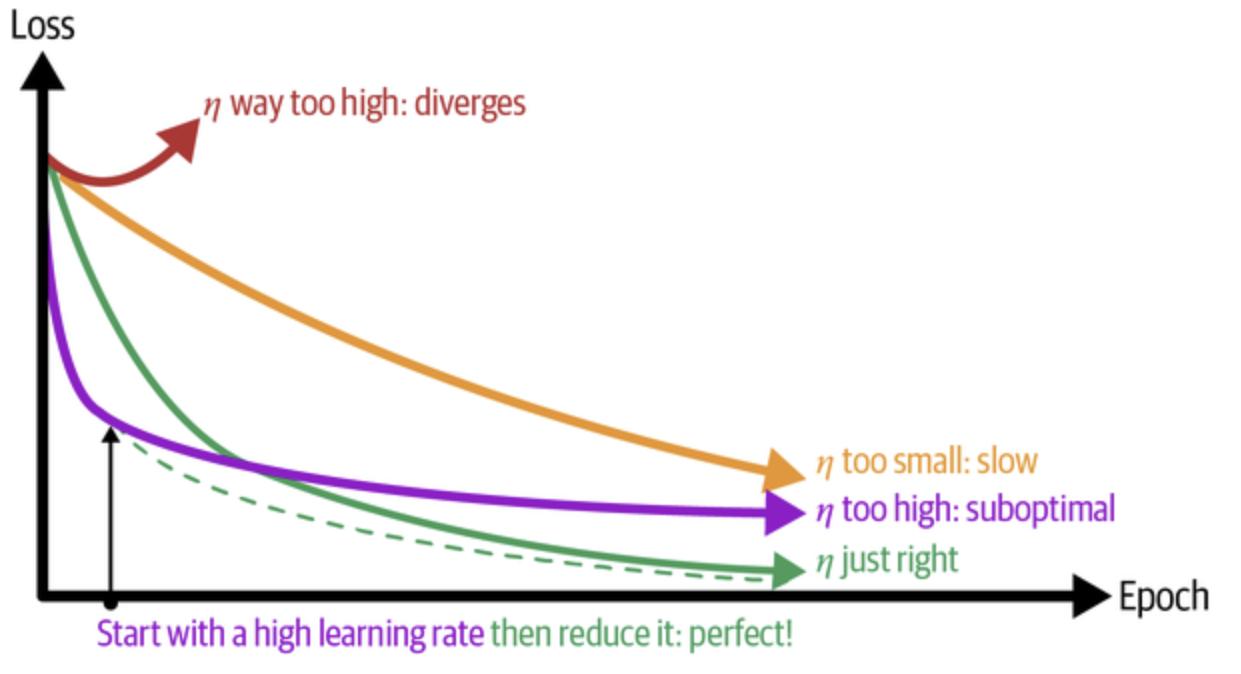

In [1]:
from IPython.display import Image
Image("Figs/LearningRate.png",width=600)

- These are some common learning schedules:

    - **Power scheduling**:
    $$\begin{align*}
        \eta(t)=\frac{\eta_0}{(1+t/s)^c}
    \end{align*}$$

    - Here, $t$ is number of steps (in practice, a step is an epoch), $\eta_0$ is the initial rate, $c$ is the power (typically $c=1$), and $s$ is the step hyperparameter. Note that, with the default value of $c=1$, the learning rate is $\tfrac{\eta_0}{1+k}$ after $k$ steps. So, the power learning schedule drops quickly and then it drops more and more slowly.

    - **Exponential scheduling**:
        $$\begin{align*}
        \eta(t)=\eta_0(0.1)^{t/s}
        \end{align*}$$

    - Here $t$ is the number of steps, $\eta_0$ is the initial rate and $s$ is the step hyperparameter. Note that, the learning rate is cut down to a tenth every $s$ steps.

    - **Piecewise constant scheduling**: As the name suggest, use a decreasing step function. For example, $\eta=0.1$ for 5 epochs, then $\eta = 0.01$ for the next 10 epochs, etc.

    - **Performance scheduling**: Similar to early stopping, measure the validation error at regular intervals (e.g. at the end of each epoch). Decrease the learning rate (say divide it by two) if the validation error has not improved over the past, say, 5 epochs.

- In practice, exponential scheduling and performance scheduling work best.

- Let us try implementing a learning schedule using the fashion MNIST dataset.

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from absl import logging

In [4]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
X_train, X_valid, X_test = X_train / 255, X_valid / 255, X_test / 255

In [5]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [6]:
def reset_session(seed=42):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    tf.keras.backend.clear_session()

- First we create a MLP, indicate NAG (Nesterov Accelerated Gradient) as the solver, and save it so that we can load and run it later. (Throughout we use `sparse_categorical_accuracy` as the metric, which is the same as `accuracy`, but this fixes a bug with printing the correct validation accuracy after saving and loading in TensorFlow).

In [8]:

reset_session()
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model.add(tf.keras.layers.Dense(n_hidden, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["sparse_categorical_accuracy"])

model.save("untrained.keras")

- As a benchmark, let us run it without a learning schedule

In [10]:
reset_session()
logging.set_verbosity(logging.ERROR) #This is to suppress some warnings when loading the model
model = tf.keras.models.load_model("untrained.keras")
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("NAG_unscheduled.keras",
                                                save_best_only=True)
run = model.fit(X_train, y_train, epochs=20,
                validation_data=(X_valid, y_valid),
                callbacks=[checkpoint_cb], verbose=0)
pd.DataFrame(run.history).iloc[-11:]

,loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy
9,0.290974,0.894527,0.359496,0.8622
10,0.283787,0.896964,0.360289,0.8622
11,0.276824,0.899418,0.354962,0.8646
12,0.270340,0.901745,0.353090,0.8662
13,0.264463,0.903582,0.357600,0.8646
14,0.258955,0.905727,0.354846,0.8668
15,0.253636,0.907291,0.357436,0.8660
16,0.248444,0.910236,0.354807,0.8680
17,0.243394,0.912273,0.357840,0.8674
18,0.238558,0.914182,0.356333,0.8676


- Note that the loss reaches 0.2338 after 20 epochs.

- For this comparison of various learning schedules , we care about the loss rather than the validation loss. Why?

- Because we want to see which learning schedule gives the fastest training, and models are trained by minimizing loss.

- Let us apply a learning schedule.

- Some Keras optimizers have built-in learning schedules. For example, the `InverseTimeDecay` method of keras corresponds to the power schedule with $c=1$.

In [12]:
reset_session()
logging.set_verbosity(logging.ERROR) #This is to suppress some warnings when saving the model
model = tf.keras.models.load_model("untrained.keras")
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
     initial_learning_rate=  0.01,
     decay_steps = 1,
    decay_rate = 1e-4) #see socumentation at https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/InverseTimeDecay

optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9, nesterov=True)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["sparse_categorical_accuracy"])

- This time, we reach a loss of 0.1796 after 20 epochs. This is an improvement.

In [13]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("NAG_powerSch.keras",
                                                save_best_only=True)
run = model.fit(X_train, y_train, epochs=20,
                validation_data=(X_valid, y_valid),
                callbacks=[checkpoint_cb], verbose=0)
pd.DataFrame(run.history).iloc[-11:]

,loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy
9,0.245267,0.908636,0.338173,0.8762
10,0.237396,0.911673,0.339176,0.8758
11,0.229513,0.914073,0.345369,0.8748
12,0.221813,0.917436,0.347882,0.8780
13,0.214512,0.920109,0.356823,0.8750
14,0.208247,0.922982,0.356904,0.8792
15,0.201667,0.925109,0.361295,0.8768
16,0.196132,0.927182,0.368474,0.8764
17,0.190243,0.929655,0.371604,0.8780
18,0.185176,0.931491,0.384288,0.8778


- In Keras, you can also define your own learning schedule and pass it as a callback to `.fit()`. Let us illustrate this for the exponential schedule.

- First, we reload the untrained neural net.

In [17]:
reset_session()
model = tf.keras.models.load_model("untrained.keras")

- You need to pass on a learning schedule function to `tf.keras.callbacks.LearningRateScheduler()`. This first function takes in the values $\eta_0$ and $s$ and outputs the second function $\eta(t)=\eta_0(0.1)^{t/s}$

In [18]:
def exponential_decay(lr0, s):
    return lambda epoch: lr0 * 0.1**(epoch / s)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay(lr0=0.01,s=20))

- Once you have created the LearningRateScheduler, you can pass it to the ``.fit()`` function the same way we pass the other callbacks for early stopping.

In [20]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("NAG_ExpSch.keras",
                                                save_best_only=True)
run = model.fit(X_train, y_train, epochs=20,
                validation_data=(X_valid, y_valid),
                callbacks=[checkpoint_cb, lr_scheduler], verbose=0)
pd.DataFrame(run.history).iloc[-11:]

,loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy,learning_rate
9,0.238175,0.911818,0.368967,0.8696,0.003548
10,0.229030,0.915655,0.368053,0.8696,0.003162
11,0.219509,0.918782,0.365189,0.8702,0.002818
12,0.211184,0.921727,0.361229,0.8732,0.002512
13,0.203469,0.924945,0.361021,0.8724,0.002239
14,0.196931,0.927200,0.364860,0.8724,0.001995
15,0.190716,0.929800,0.363062,0.8758,0.001778
16,0.185166,0.931818,0.363602,0.8776,0.001585
17,0.179732,0.933691,0.364729,0.8802,0.001413
18,0.174916,0.935582,0.365794,0.8812,0.001259


- Exponential learning schedule reduces the learning rate more than power scheduling.

- Note that the ``.history()`` now also returns the learning rate for each epoch.

- To better illustrate the learning rates, we use two vertical axes, one specifically for the learning rate. This is done using the ``.twinx()`` line.

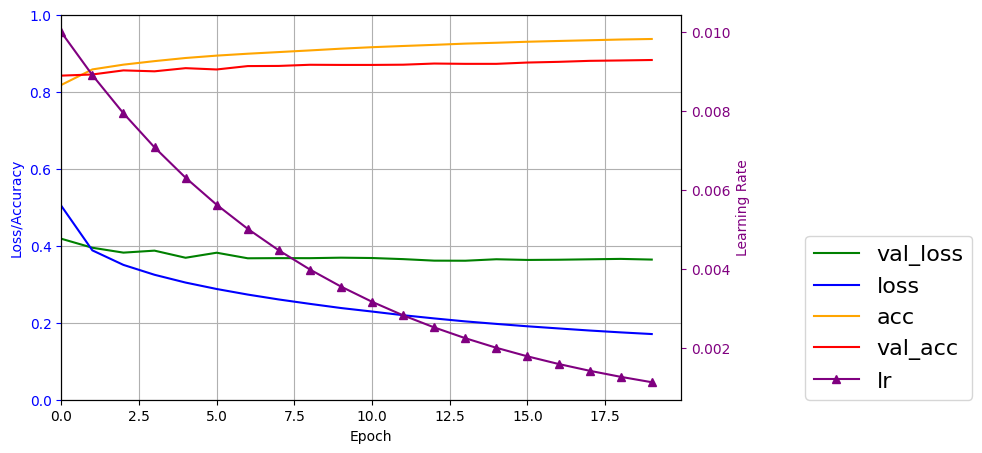

In [24]:
plt.figure(figsize=(8,5))
ln1=plt.plot(run.epoch, run.history["val_loss"], "g-", label='val_loss')
ln2=plt.plot(run.epoch, run.history["loss"], "b-", label='loss')
ln3=plt.plot(run.epoch, run.history["sparse_categorical_accuracy"], "-", color='orange', label='acc')
ln4=plt.plot(run.epoch, run.history["val_sparse_categorical_accuracy"], "r-", label='val_acc')
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, None)
plt.gca().set_ylim(0, 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ln5 = ax2.plot(run.epoch, run.history["learning_rate"], "^-", color='purple', label='lr')
ax2.set_ylabel("Learning Rate", color='purple')
ax2.tick_params('y', colors='purple')

lns = ln1+ln2+ln3+ln4+ln5
labs = [l.get_label() for l in lns]
plt.legend(lns, labs, loc=(1.2,0), fontsize=16)
plt.show()

- Finally, let us show how to implement performance scheduling in Keras.

- For this, we need to use a different callback function, namely `tf.keras.callbacks.ReduceLROnPlateau`.

- Let us reload the untrained model, and set the learning rate to a higher value than before.

In [27]:
reset_session()
model = tf.keras.models.load_model("untrained.keras")

In [28]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9, nesterov=True)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["sparse_categorical_accuracy"])

- The following code uses a learning schedule that cuts the learning rate by `factor=0.5` each time the validation loss hasn't improved for `patience=5` epochs.

- As a demonstration we will use early stopping. Note that `patience` for early stopping should be greater than `patience` for performance scheduling.

In [30]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("NAG_PerformanceSch.keras",
                                                save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                  min_delta=0.001,
                                                  restore_best_weights=True)
run = model.fit(X_train, y_train, epochs=200,
                validation_data=(X_valid, y_valid),
                callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler], verbose=0)
pd.DataFrame(run.history).iloc[-11:]

,loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy,learning_rate
12,0.251139,0.907982,0.375376,0.8748,0.010
13,0.234838,0.911436,0.395067,0.8688,0.010
14,0.226166,0.914455,0.405528,0.8694,0.010
15,0.219157,0.917291,0.418549,0.8692,0.010
16,0.212855,0.919491,0.420264,0.8674,0.010
17,0.215272,0.917691,0.401163,0.8772,0.010
18,0.189984,0.928564,0.399276,0.8720,0.005
19,0.179693,0.932127,0.409116,0.8726,0.005
20,0.173111,0.934382,0.425475,0.8738,0.005
21,0.168204,0.935782,0.437767,0.8742,0.005


- The learning curves below show the change in the learning rate according to the performance schedule.

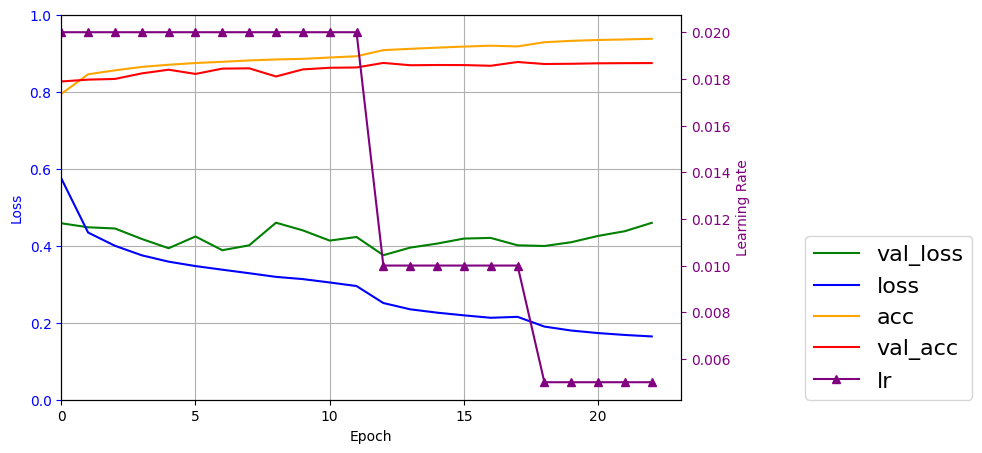

In [33]:
plt.figure(figsize=(8,5))
ln1=plt.plot(run.epoch, run.history["val_loss"], "g-", label='val_loss')
ln2=plt.plot(run.epoch, run.history["loss"], "b-", label='loss')
ln3=plt.plot(run.epoch, run.history["sparse_categorical_accuracy"], "-", color='orange', label='acc')
ln4=plt.plot(run.epoch, run.history["val_sparse_categorical_accuracy"], "r-", label='val_acc')
plt.xlabel("Epoch")
plt.ylabel("Loss", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, None)
plt.gca().set_ylim(0, 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ln5 = ax2.plot(run.epoch, run.history["learning_rate"], "^-", color='purple', label='lr')
ax2.set_ylabel("Learning Rate", color='purple')
ax2.tick_params('y', colors='purple')

lns = ln1+ln2+ln3+ln4+ln5
labs = [l.get_label() for l in lns]
plt.legend(lns, labs, loc=(1.2,0), fontsize=16)
plt.show()

# 2. Regularizing DNNs

- DNNs usually have thousands of parameters (if not millions). With this many parameters, they are prone to overfitting.

- We have already implemented a great approach to obtain a good bias/variance tradeoff, namely **early stopping**.

- Furthermore, as we mentioned earlier, BN which was originally designed to tackle the vanishing gradient problem, also acts as a regularization technique.

- In practice, however, these two methods may not be enough. So, let us discuss other popular regularization techniques for DNNs.

## 2.1. $\ell_1$ and $\ell_2$ regularization 

- As you can guess, we can add $\ell_1$ (as in lasso regression), $\ell_2$ (as in ridge regression), or a combination of $\ell_1$ and $\ell_2$ norms of the connection weights to the loss function when training the network.

- As we have already discussed these types of regularizations, there is not much to say about the mathematical details. So, let us directly dive into implementing them.

- You can pass a kernel_regularizer argument to many Keras layers. To add $\ell_2$ regularizer with regularization hyperparameter 0.01, we can use

In [34]:
tf.keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal",
                   kernel_regularizer=tf.keras.regularizers.l2(0.01))

<Dense name=dense, built=False>

- To add $\ell_1$ regularizer with regularization hyperparameter 0.1, we can use

In [35]:
tf.keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal",
                   kernel_regularizer=tf.keras.regularizers.l1(0.1))

<Dense name=dense_1, built=False>

- To add a combination of $\ell_1$ regularizer with regularization hyperparameter 0.1 and an $\ell_2$ with weight 0.01, use

In [36]:
tf.keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal",
                   kernel_regularizer=tf.keras.regularizers.l1_l2(0.1, 0.01))

<Dense name=dense_2, built=False>

- You can use other activation or initialization techniques, of course.

- As you can see, our layers are starting to have many hyperparameters.

In [38]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model.add(tf.keras.layers.Dense(n_hidden, activation="elu",kernel_initializer="he_normal",
                                kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(tf.keras.layers.Dense(10, activation="softmax",
                             kernel_regularizer=tf.keras.regularizers.l2(0.01)))
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

- This is hard to read. Also, copy-pasting a lot of repetitive arguments such as `kernel_regularizer=tf.keras.regularizers.l2(0.01)` is bad form and prone to error.

- Python provides the `functools.partial()` function to make such repetitive code more readable. By using this function, you can create a small wrapper function around another function and use it to pass on some default arguments.

In [39]:
from functools import partial
RegularizedDense = partial(tf.keras.layers.Dense,
                     activation="elu",
                     kernel_initializer="he_normal",
                     kernel_regularizer=tf.keras.regularizers.l2(0.01))

- Now, we can define the MLP as follows:

In [40]:
reset_session()
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model.add(RegularizedDense(n_hidden))
model.add(RegularizedDense(10, activation="softmax"))

- Then, we compile the model using a NAG optimizer.

In [41]:
optimizer = tf.keras.optimizers.SGD(momentum=0.9, nesterov=True)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["sparse_categorical_accuracy"])

In [42]:
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay(lr0=0.01, s=20))

- Finally, we fit the network, applying early stopping and saving the best model.

In [44]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("NAG_ExpSch_l2.keras",
                                                save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                  min_delta=0.001,
                                                  restore_best_weights=True)
run = model.fit(X_train, y_train, epochs=200,
                validation_data=(X_valid, y_valid),
                callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler], verbose=0)
pd.DataFrame(run.history).iloc[-11:]

,loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy,learning_rate
44,0.911632,0.836945,0.907539,0.8286,0.000063
45,0.911458,0.836891,0.907379,0.8280,0.000056
46,0.911302,0.836982,0.907250,0.8276,0.000050
47,0.911162,0.837291,0.907146,0.8282,0.000045
48,0.911037,0.837291,0.907062,0.8282,0.000040
49,0.910924,0.837345,0.906994,0.8280,0.000035
50,0.910824,0.837418,0.906939,0.8282,0.000032
51,0.910733,0.837473,0.906892,0.8280,0.000028
52,0.910652,0.837582,0.906850,0.8284,0.000025
53,0.910579,0.837745,0.906811,0.8288,0.000022


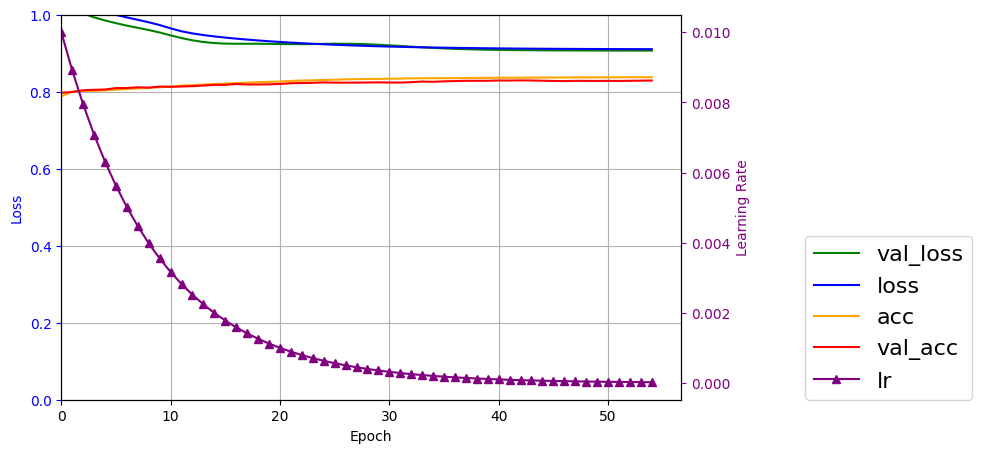

In [45]:
plt.figure(figsize=(8,5))
ln1=plt.plot(run.epoch, run.history["val_loss"], "g-", label='val_loss')
ln2=plt.plot(run.epoch, run.history["loss"], "b-", label='loss')
ln3=plt.plot(run.epoch, run.history["sparse_categorical_accuracy"], "-", color='orange', label='acc')
ln4=plt.plot(run.epoch, run.history["val_sparse_categorical_accuracy"], "r-", label='val_acc')
plt.xlabel("Epoch")
plt.ylabel("Loss", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, None)
plt.gca().set_ylim(0, 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ln5 = ax2.plot(run.epoch, run.history["learning_rate"], "^-", color='purple', label='lr')
ax2.set_ylabel("Learning Rate", color='purple')
ax2.tick_params('y', colors='purple')

lns = ln1+ln2+ln3+ln4+ln5
labs = [l.get_label() for l in lns]
plt.legend(lns, labs, loc=(1.2,0), fontsize=16)
plt.show()

## 2.2. Dropout

- Dropout is one of the most popular techniques for regularizing DNNs.

- The idea is very simple: during each step of training, each neuron (including input neurons but excluding the output neurons) is temporarily "dropped out" with probability $p\in (0,1)$, called the dropout probability. A dropped out neuron will be completely ignored (as if it didn't exist, mathematically a dropped out neuron simply outputs 0) during that step of training. It will be back in the next training step assuming it's not dropped out again.

- Generally speaking, dropout forces neurons to make "more connections across" the network. As a result, each neuron will rely on inputs from more neurons, and will be less "specialized" to a selected few neurons. The resulting network will be less sensitive to small changes in the input. Thus, it will not fit noise in the training set and achieve a better out-of-sample error.

- To increase regularization, increase $p$.

- Dropout includes the input neurons but excludes the output neurons.

- It can also help to increase the dropout rate for large layers, and reduce it for small ones.

- Many state-of-the-art architectures only use dropout at the last hidden layer, and this can be tried if full dropout is not performing well.

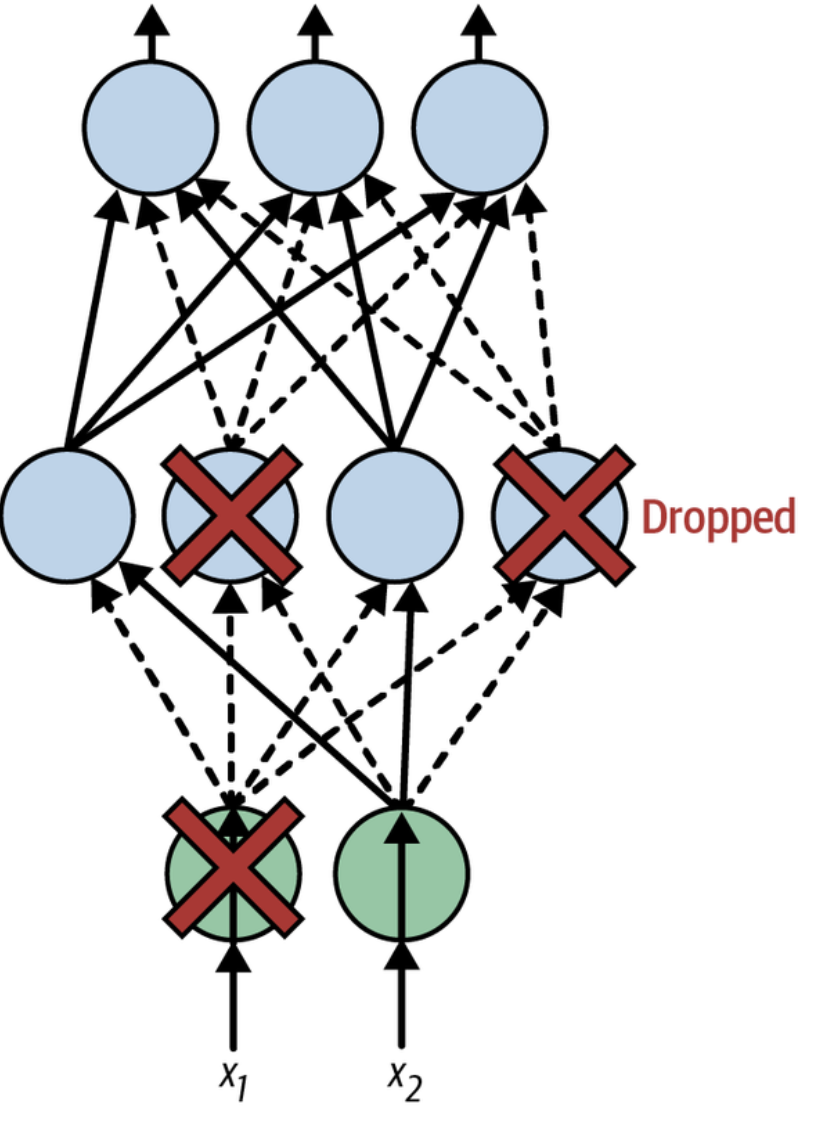

In [46]:
Image("Figs/Dropout.png",width=400)

- Note that different neurons will be dropped out during different training iterations. Therefore, at each step of training, we train a different neural network.

- Excluding the output layer, if the network has $N$ neurons , the number of possible networks after a dropout is $2^N$. This number is huge for even "small" ANNs:

In [47]:
2**400

2582249878086908589655919172003011874329705792829223512830659356540647622016841194629645353280137831435903171972747493376

- As a result, we may (almost certainly) end up training a different network at each step of training. These different networks share neurons (and connections weights etc.).

- In essence, dropout is a type of ensemble learning. You create a large ensemble of similar neural networks, each one is obtained by removing randomly selected neurons from the original network.

- Note that we apply dropout only during training. When predicting (or evaluating on validation and test sets), we use all the neurons.

- This will introduce two issues, however.

- Firstly, we have to adjust the connection weights before we can use them for prediction. Consider the case when the dropout probability is $p=0.5$.

- During training, on average, only 50% of the neurons from the previous layer are feeding to a neuron in the next layer. If we keep the weight as is, and feed 100% of the neurons, then each neuron will get a total input signal roughly twice as large as what the network was trained on and will be unlikely to perform well.

- This problem can be easily corrected: simply multiply the connection weights by the "keep probability" $1-p$ after training. In practice, Keras automatically does this.

- Note: When using BN, while you can try regular dropout (the order could be Dense, BatchNormalization, Dropout), dropout may not necessarily help in this situation.

- Dropouts are implemented in Keras through `tf.keras.layers.Dropout`. You can pass the dropout probability as the rate argument. Put the dropout layer after the layer to which you want to apply dropout.

In [65]:
reset_session()
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
model.add(tf.keras.layers.Dropout(rate=0.2))
for n_hidden in (300, 100, 50, 50, 50):
    model.add(tf.keras.layers.Dense(n_hidden, activation="elu",
                                 kernel_initializer="he_normal"))
    model.add(tf.keras.layers.Dropout(rate=0.2))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [50]:
optimizer = tf.keras.optimizers.SGD(momentum=0.9, nesterov=True)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["sparse_categorical_accuracy"])

- Let us train the network.

In [51]:
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay(lr0=0.01, s=20))

In [53]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("NAG_ExpSch_Dropout.keras",
                                                save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                  min_delta=0.001,
                                                  restore_best_weights=True)
run = model.fit(X_train, y_train, epochs=200,
                validation_data=(X_valid, y_valid),
                callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler], verbose=0)
pd.DataFrame(run.history).iloc[-11:]

,loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy,learning_rate
34,0.372432,0.864836,0.325547,0.8796,0.000200
35,0.369028,0.865509,0.326213,0.8800,0.000178
36,0.370108,0.864527,0.325990,0.8796,0.000158
37,0.369828,0.865545,0.326167,0.8790,0.000141
38,0.366794,0.865418,0.326624,0.8792,0.000126
39,0.370652,0.863727,0.326278,0.8798,0.000112
40,0.371018,0.865327,0.326334,0.8794,0.000100
41,0.367618,0.865982,0.326118,0.8796,0.000089
42,0.371050,0.864091,0.326230,0.8794,0.000079
43,0.372740,0.863291,0.326916,0.8788,0.000071


- The second problem is that, as we explained above, the network(s) we train are not the network we use for prediction. This creates some problems.

- One example is when interpreting the learning curves (say, you want to see if you are overfitting), the in-sample metric reported by Keras during training are for the dropout (i.e. smaller) networks. While the validation (i.e. out-of-sample) metric is based on the full network. Using these values in your learning curves would disguise overfitting. It will make in-sample performance look worse (smaller networks make larger error), thus, it may reduce the gap between the in sample and out-of-sample error in the learning curves.

- In short, the in-sample metrics (i.e. `loss` and `accuracy`) that are reported during training are not comparable to the out-of-sample metrics (i.e. `val_loss` and `val_accuracy`).

- So the usual learning curves obtained through ``.fit()`` are misleading.

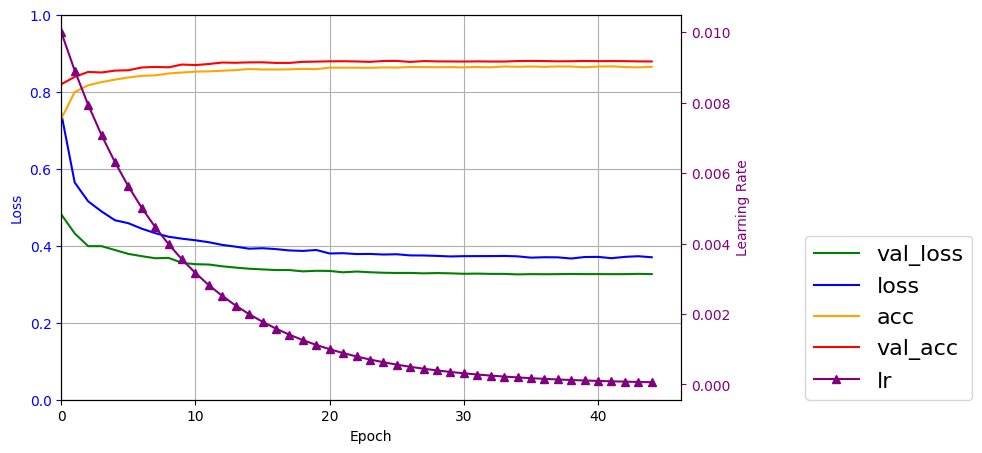

In [55]:
plt.figure(figsize=(8,5))
ln1=plt.plot(run.epoch, run.history["val_loss"], "g-", label='val_loss')
ln2=plt.plot(run.epoch, run.history["loss"], "b-", label='loss')
ln3=plt.plot(run.epoch, run.history["sparse_categorical_accuracy"], "-", color='orange', label='acc')
ln4=plt.plot(run.epoch, run.history["val_sparse_categorical_accuracy"], "r-", label='val_acc')
plt.xlabel("Epoch")
plt.ylabel("Loss", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, None)
plt.gca().set_ylim(0, 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ln5 = ax2.plot(run.epoch, run.history["learning_rate"], "^-", color='purple', label='lr')
ax2.set_ylabel("Learning Rate", color='purple')
ax2.tick_params('y', colors='purple')

lns = ln1+ln2+ln3+ln4+ln5
labs = [l.get_label() for l in lns]
plt.legend(lns, labs, loc=(1.2,0), fontsize=16)
plt.show()

- To fix this issue, always calculate your in-sample error on the training set after training with dropout.

In [56]:
model.evaluate(X_train, y_train)

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 903us/step - loss: 0.2866 - sparse_categorical_accuracy: 0.8922


[0.28957465291023254, 0.8923090696334839]

- Let us also calculate the out-of-sample metrics, which coincide with what was reported during training.

In [57]:
model.evaluate(X_valid, y_valid)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3365 - sparse_categorical_accuracy: 0.8751


[0.3255469501018524, 0.8795999884605408]

- While the misleading learning curve indicates we are not overfitting, actually there is a tiny amount of overfitting.

- If you are not using BN, and are relying on self-normalization of SELU neurons (with LeCun initialization), then be aware that using the regular dropout method will ruin this self-normalization. There is a remedy however, use alpha dropout, which is a variation of dropout that preserves self-normalization. This is implemented using `tf.keras.layers.AlphaDropout`. However, there is a conflict in the current version of keras (3.1.1) and the newest version of tensorflow, so to alpha dropout one needs to install a previous version of tensorflow.

# 3. Practical guidelines for training DNNs

- We covered a range of methods to train DNNs. So, which one should you use?

- You can always try grid search with cross validation to see what works well for your problem. However, it is good to have a guideline about default configurations. But these are not hard rules.

- Start with the following setting:

    - **Activation/initialization**: ReLU if shallow; Swish if deep. He initialization.
    - **Normalization**: None if shallow; batch normalization if deep
    - **Regularization**: Early stopping or weight decay (AdamW) if needed.
    - **Optimizer**: Nesterov accelerated gradients or AdamW.
    - **Learning rate scheduling**: Performance scheduling.

- Tweak the setting above in the following scenarios:
    - You can also try a model that self-normalizes, such as using SELU. In this case, add alpha dropout if needed for regularization.
    - If your model does not self-normalize, try a ReLU variant such as ELU or Swish (with the correct initialization) and apply BN after each layer. If the network is overfitting, try a $\ell_2$ normalization or dropout.
    - Another learning rate schedule for good results you can try is 1cycle (see textbook).
    - If you need a low-latency model (fast prediction), use fewer layers, avoid BN, and use leaky ReLUs. Having a sparse model with $\ell_1$ regularization also helps.